# **Predicting Customer Habits**

### **Introducing the Problem**
One consistent part of the lives of everyday people is the process of shopping. While some people take to it and invest a significantly greater amount of time and money, even penny pinchers still have to go out and buy something relatively frequently. Stores do their best to keep shelves stocked with customer favorites and even tailor the layout of stores to encourage customers to buy the greatest amount of goods. So while stores may attempt to provide the greatest selection to customers, revenue is often the driving factor behind most or all of these decisions. This project aims to create a model or models that can provide insights to stores on how they may further expand their profits. These models are primarily focused on determining if a customer would subsribe to a store's service as well as the amount that a customer will spend during a visit.

In [1]:
%pip install category_encoders
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
%matplotlib inline

# warnings: Provides a way to suppress or manage specific warning messages.
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# category_encoders: Provides various encoding schemes to handle categorical variables.
import category_encoders as ce

from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.cluster import KMeans, AgglomerativeClustering

### **Introducing the Data**
The dataset used in this project consists of data characterizing the shopping habits of customers. There are 18 features to this dataset including age, gender, location, amount spent, item purchased, subscription status and a number of other measures. There are a total of 3,900 observations and the file is 407 kB in size. Below is a list of all features included in the file. The set was gathered from kaggle and the link will be provided in the references.

In [2]:
#Read in the csv
df = pd.read_csv('shopping_behavior_updated.csv')

In [3]:
#Gives info on the columns + their data type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Customer ID             3900 non-null   int64  
 1   Age                     3900 non-null   int64  
 2   Gender                  3900 non-null   object 
 3   Item Purchased          3900 non-null   object 
 4   Category                3900 non-null   object 
 5   Purchase Amount (USD)   3900 non-null   int64  
 6   Location                3900 non-null   object 
 7   Size                    3900 non-null   object 
 8   Color                   3900 non-null   object 
 9   Season                  3900 non-null   object 
 10  Review Rating           3900 non-null   float64
 11  Subscription Status     3900 non-null   object 
 12  Shipping Type           3900 non-null   object 
 13  Discount Applied        3900 non-null   object 
 14  Promo Code Used         3900 non-null   

#### **Pre-Processing**
Here, we are taking a few initial steps to preprocess our data. We can see below that there are no null values that need to be dealt with in our data. For a bit of feature engineering, we decided one useful option would be to place a bin on each observation as to how much they spent, creating separations in 25$ increments. Further preprocessing will be done later on as well.

In [4]:
# Check for null values in each column of the DataFrame and filter columns with nulls
null_counts = df.isnull().sum()
columns_with_nulls = null_counts[null_counts > 0]

# Display the names of columns that have null values and their respective count
print(columns_with_nulls)

Series([], dtype: int64)


In [5]:
# Define bin edges and labels for the bins
bin_edges = [0, 25, 50, 75, 100, float('inf')]
bin_labels = [0, 1, 2, 3, 4]

# Use pandas cut function to bin the 'Purchase Amount (USD)' column
df['Purchase_Amount_Binned'] = pd.cut(df['Purchase Amount (USD)'],
                                       bins=bin_edges,
                                       labels=bin_labels,
                                       include_lowest=True)

# Display the first few rows of the dataframe to verify the binning
df.head(20)

,Customer ID,Age,Gender,Item Purchased,Category,Purchase Amount (USD),Location,Size,Color,Season,Review Rating,Subscription Status,Shipping Type,Discount Applied,Promo Code Used,Previous Purchases,Payment Method,Frequency of Purchases,Purchase_Amount_Binned
0,1,55,Male,Blouse,Clothing,53,Kentucky,L,Gray,Winter,3.1,Yes,Express,Yes,Yes,14,Venmo,Fortnightly,2
1,2,19,Male,Sweater,Clothing,64,Maine,L,Maroon,Winter,3.1,Yes,Express,Yes,Yes,2,Cash,Fortnightly,2
2,3,50,Male,Jeans,Clothing,73,Massachusetts,S,Maroon,Spring,3.1,Yes,Free Shipping,Yes,Yes,23,Credit Card,Weekly,2
3,4,21,Male,Sandals,Footwear,90,Rhode Island,M,Maroon,Spring,3.5,Yes,Next Day Air,Yes,Yes,49,PayPal,Weekly,3
4,5,45,Male,Blouse,Clothing,49,Oregon,M,Turquoise,Spring,2.7,Yes,Free Shipping,Yes,Yes,31,PayPal,Annually,1
5,6,46,Male,Sneakers,Footwear,20,Wyoming,M,White,Summer,2.9,Yes,Standard,Yes,Yes,14,Venmo,Weekly,0
6,7,63,Male,Shirt,Clothing,85,Montana,M,Gray,Fall,3.2,Yes,Free Shipping,Yes,Yes,49,Cash,Quarterly,3
7,8,27,Male,Shorts,Clothing,34,Louisiana,L,Charcoal,Winter,3.2,Yes,Free Shipping,Yes,Yes,19,Credit Card,Weekly,1
8,9,26,Male,Coat,Outerwear,97,West Virginia,L,Silver,Summer,2.6,Yes,Express,Yes,Yes,8,Venmo,Annually,3
9,10,57,Male,Handbag,Accessories,31,Missouri,M,Pink,Spring,4.8,Yes,2-Day Shipping,Yes,Yes,4,Cash,Quarterly,1


### **Visualizations**
Below are some visualizations to try and help us understand and explore some initial relationships we may be able to utilize when it comes time to develop our models and make predictions. We begin with a set of histograms of variables plotted against the frequencies of the variables. We have also plotted relationships between purchase amount and clothing type, clothing size and season to see if they may have any correlation with one another.

C:\Users\ngray\AppData\Local\Temp\ipykernel_19072\477691338.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[idx].set_xticklabels(current_labels, rotation=0)
C:\Users\ngray\AppData\Local\Temp\ipykernel_19072\477691338.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[idx].set_xticklabels(current_labels, rotation=0)
C:\Users\ngray\AppData\Local\Temp\ipykernel_19072\477691338.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[idx].set_xticklabels(current_labels, rotation=0)
C:\Users\ngray\AppData\Local\Temp\ipykernel_19072\477691338.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[idx].set_xticklabels(current_labels, rotation=0)
C:\Users\ngray\AppData\Local\Temp\ipykernel_19072\477691338.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[idx].set_xticklabels(current_labels, rotation=0)
C:\Users\n

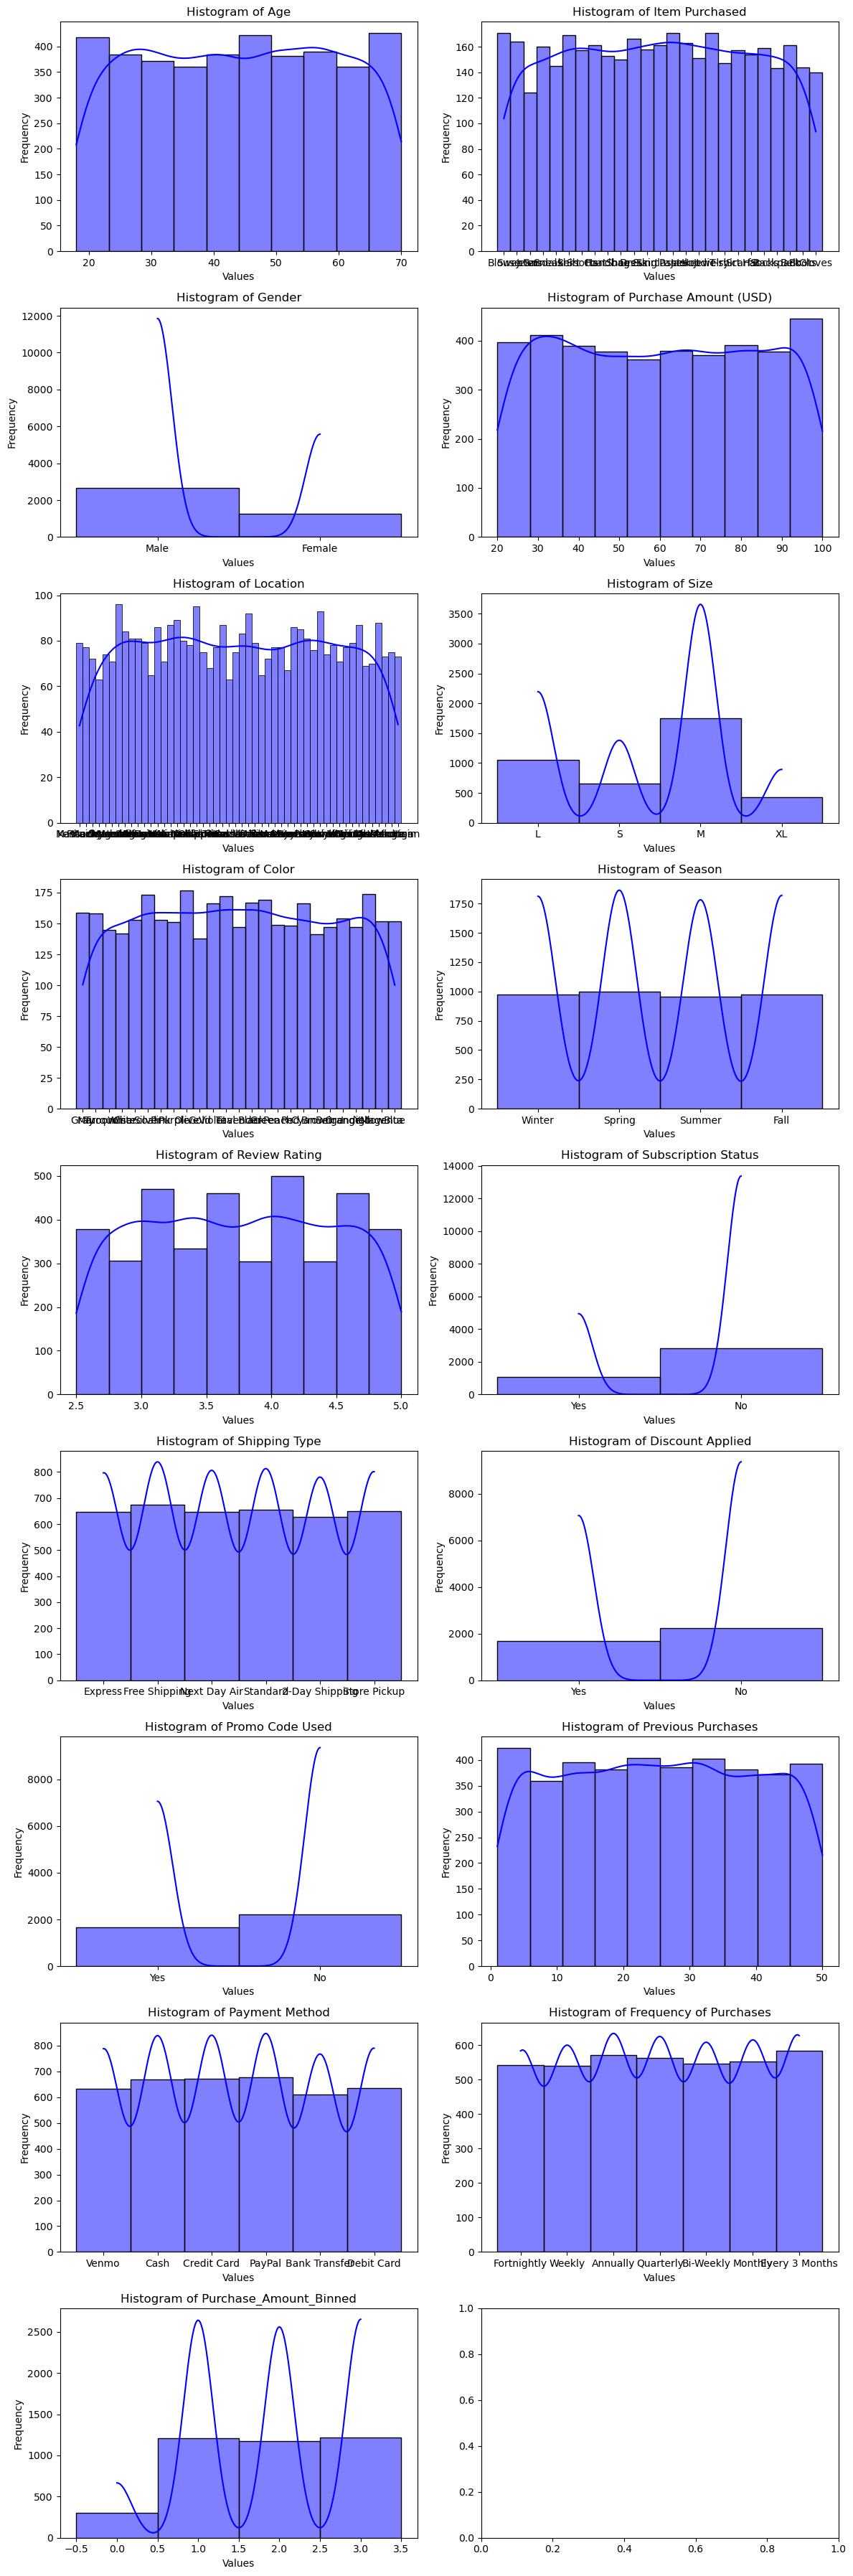

In [6]:
# Variables we want to visualize
hist_feat_int = df[['Age', 'Item Purchased','Gender', 'Purchase Amount (USD)', 'Location', 'Size', 'Color', 'Season', 'Review Rating', 'Subscription Status','Shipping Type', 'Discount Applied', 'Promo Code Used', 'Previous Purchases', 'Payment Method', 'Frequency of Purchases', 'Purchase_Amount_Binned']]

n_features = len(hist_feat_int.columns)
n_cols = 2  # number of histograms per row
n_rows = (n_features + n_cols - 1) // n_cols  # Calculate required number of rows

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows))

# Flatten the axes array for easier indexing
axes = axes.ravel()

for idx, feature in enumerate(hist_feat_int.columns):
    sns.histplot(hist_feat_int[feature], color='blue', bins=10, kde=True, ax=axes[idx])
    axes[idx].set_title(f'Histogram of {feature}')
    axes[idx].set_xlabel('Values')
    axes[idx].set_ylabel('Frequency')
    current_labels = axes[idx].get_xticklabels()
    axes[idx].set_xticklabels(current_labels, rotation=0)

plt.tight_layout()
plt.show()

From these histograms we can glean a few pieces of information. Of the individuals researched, the majority were male, medium and large were the most popular clothing sizes, most customers were not subscribed to a stores service, and very few customers spent under 25$.

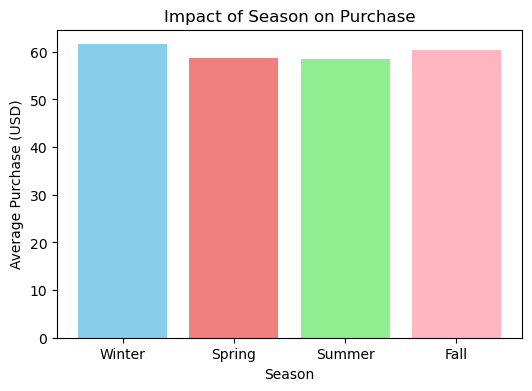

In [7]:
#The impact of season on purchase amount
seasons = df['Season'].unique()
average_purchase_by_season = df.groupby('Season')['Purchase Amount (USD)'].mean()

plt.figure(figsize=(6, 4))
plt.bar(seasons, average_purchase_by_season, color=['skyblue', 'lightcoral', 'lightgreen', 'lightpink'])
plt.title("Impact of Season on Purchase")
plt.xlabel("Season")
plt.ylabel("Average Purchase (USD)")
plt.show()

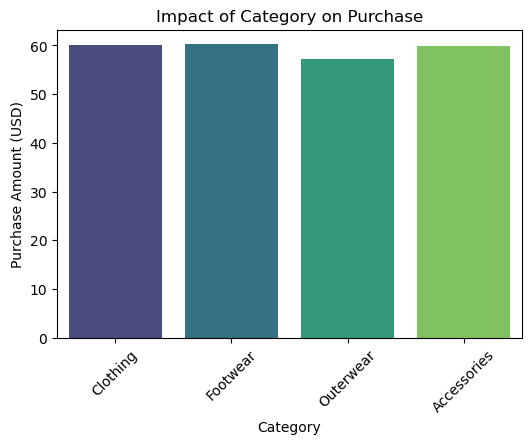

In [8]:
#impact of category on purchase amount
plt.figure(figsize=(6, 4))
sns.barplot(x='Category', y='Purchase Amount (USD)', data=df, ci=None, palette='viridis')
plt.title("Impact of Category on Purchase")
plt.xticks(rotation=45)
plt.show()

C:\Users\ngray\anaconda3\Lib\site-packages\seaborn\categorical.py:3544: UserWarning: 38.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\ngray\anaconda3\Lib\site-packages\seaborn\categorical.py:3544: UserWarning: 10.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\ngray\anaconda3\Lib\site-packages\seaborn\categorical.py:3544: UserWarning: 65.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\ngray\anaconda3\Lib\site-packages\seaborn\categorical.py:3544: UserWarning: 50.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\ngray\anaconda3\Lib\site-packages\seaborn\categorical.py:3544: UserWarning: 22.0% of the points

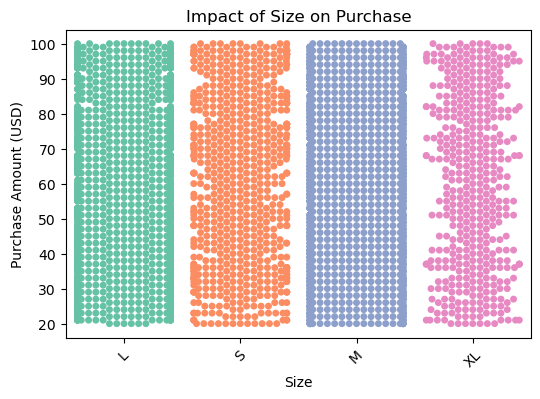

In [9]:
#Impact on size by purchase amount
plt.figure(figsize=(6, 4))
sns.swarmplot(x='Size', y='Purchase Amount (USD)', data=df, palette='Set2')
plt.title("Impact of Size on Purchase")
plt.xlabel('Size')
plt.ylabel('Purchase Amount (USD)')
plt.xticks(rotation=45)
plt.show()

After looking at these graphics, most of the relationships don't seem to have much related, but we can see that spending is a small amount higher in fall and winter, possibly because of gift purchases for the holidays. It also seems while very slight, it appears that those who purchase XL size clothes seem to spend less on clothes more often.

In [10]:
location_counts = df["Location"].value_counts()
print("Location Counts:\n", location_counts)

Location Counts:
 Montana           96
California        95
Idaho             93
Illinois          92
Alabama           89
Minnesota         88
Nebraska          87
New York          87
Nevada            87
Maryland          86
Delaware          86
Vermont           85
Louisiana         84
North Dakota      83
Missouri          81
West Virginia     81
New Mexico        81
Mississippi       80
Indiana           79
Georgia           79
Kentucky          79
Arkansas          79
North Carolina    78
Connecticut       78
Virginia          77
Ohio              77
Tennessee         77
Texas             77
Maine             77
South Carolina    76
Colorado          75
Oklahoma          75
Wisconsin         75
Oregon            74
Pennsylvania      74
Washington        73
Michigan          73
Alaska            72
Massachusetts     72
Wyoming           71
Utah              71
New Hampshire     71
South Dakota      70
Iowa              69
Florida           68
New Jersey        67
Hawaii          

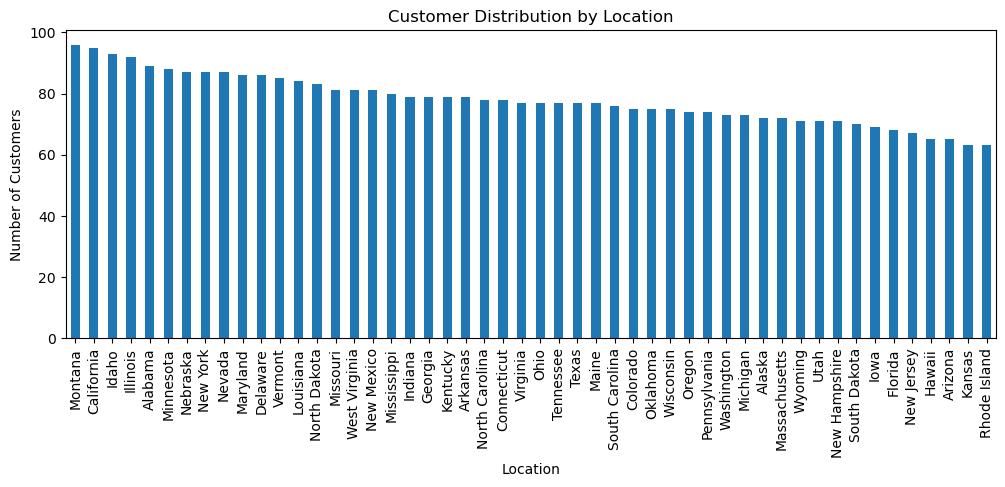

In [11]:
location_counts.plot(kind="bar", figsize=(12, 4))
plt.title("Customer Distribution by Location")
plt.xlabel("Location")
plt.ylabel("Number of Customers")
plt.show()

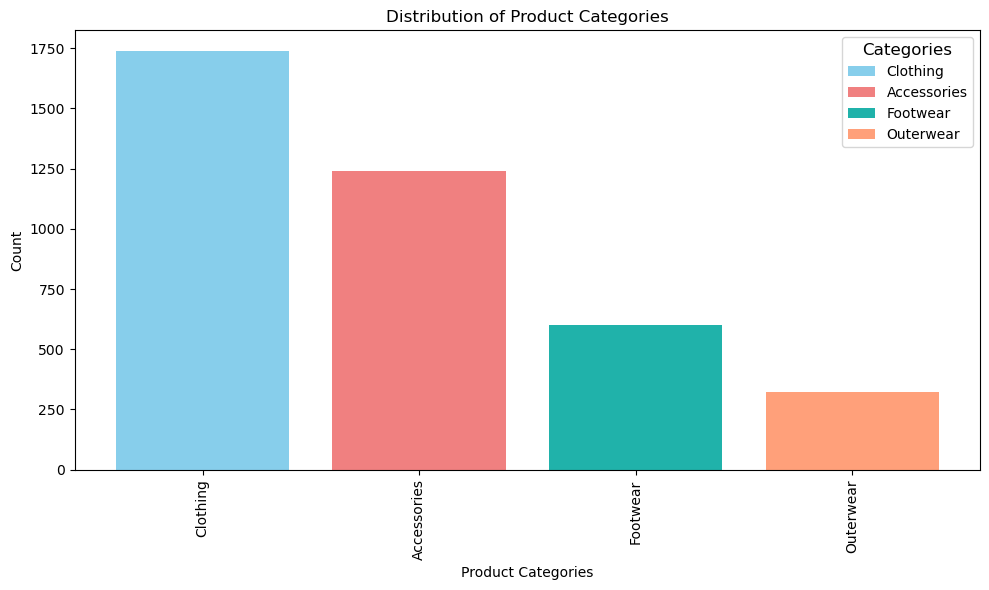

In [12]:
#Product categories and their respective counts
category_counts = df['Category'].value_counts()

# Define a list of different colors for each bar
colors = ['skyblue', 'lightcoral', 'lightseagreen', 'lightsalmon', 'lightpink']

# Create a figure and axis
plt.figure(figsize=(10, 6))
ax = plt.gca()

# Plot the bar chart with different colors for each bar
bars = plt.bar(category_counts.index, category_counts.values, color=colors)

# Add labels and title
plt.xlabel('Product Categories')
plt.ylabel('Count')
plt.title('Distribution of Product Categories')
plt.xticks(rotation=90)

# Display the chart
plt.tight_layout()

# Optionally, you can add a legend to show the correspondence between colors and categories
legend_labels = category_counts.index[:len(colors)]  # Take labels for the number of colors used
legend = plt.legend(bars[:len(colors)], legend_labels, title='Categories', loc='upper right')
plt.setp(legend.get_title(), fontsize=12)

plt.show()



In [13]:
# Define the columns to be encoded
cols_to_encode = ['Gender', 'Item Purchased', 'Category', 'Location', 'Size', 'Color', 'Season', 'Subscription Status', 'Shipping Type', 'Discount Applied', 'Promo Code Used', 'Payment Method', 'Frequency of Purchases']

# Initialize the encoder
encoder = ce.OrdinalEncoder(cols=cols_to_encode)

# Fit and transform the data
df = encoder.fit_transform(df)

# Display the resulting DataFrame (optional)
print(df.head())

   Customer ID  Age  Gender  Item Purchased  Category  Purchase Amount (USD)  \
0            1   55       1               1         1                     53   
1            2   19       1               2         1                     64   
2            3   50       1               3         1                     73   
3            4   21       1               4         2                     90   
4            5   45       1               1         1                     49   

   Location  Size  Color  Season  Review Rating  Subscription Status  \
0         1     1      1       1            3.1                    1   
1         2     1      2       1            3.1                    1   
2         3     2      2       2            3.1                    1   
3         4     3      2       2            3.5                    1   
4         5     3      3       2            2.7                    1   

   Shipping Type  Discount Applied  Promo Code Used  Previous Purchases  \
0          

In [14]:
# Display the first few rows of the dataframe to verify the binning
# Convert the 'Purchase_Amount_Binned' column to integer type
df['Purchase_Amount_Binned'] = df['Purchase_Amount_Binned'].astype(int)

### **Methodology**
To try and get a better sense of how we may relate some of our datapoints to one another, we've decided to perform clustering, and visualize these clusters via principle component analysis.

As stated earlier, some pre-processing steps were already taken, those to deal with null values and add new features. Continuing with pre-processing, a correlation matrix was made to determine the features with the strongest relationships that can be used to the greatest success in modeling and that will be included in the PCA.

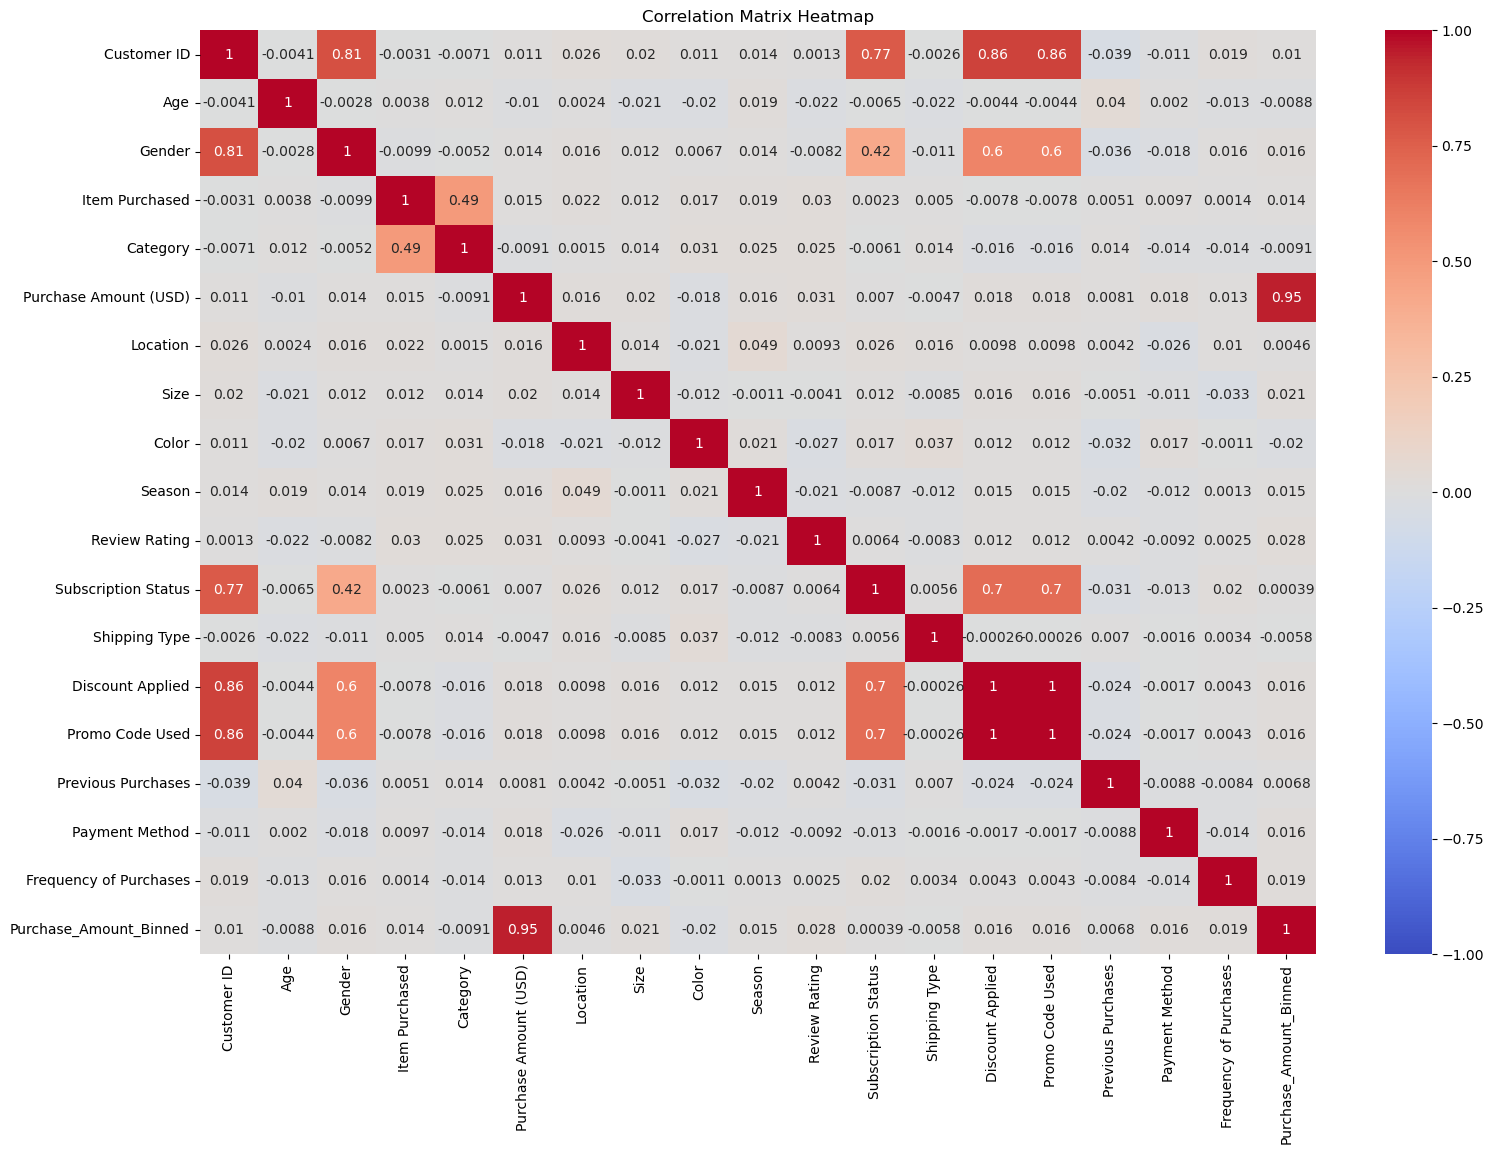

In [15]:
#Correlation matrix heatmap
import seaborn as sns
import matplotlib.pyplot as plt

numeric_cols = df.select_dtypes(include=[np.number])
correlation_matrix = numeric_cols.corr()

plt.figure(figsize=(18, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix Heatmap')
plt.show()

Clustering

In [16]:
df.head
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Customer ID             3900 non-null   int64  
 1   Age                     3900 non-null   int64  
 2   Gender                  3900 non-null   int32  
 3   Item Purchased          3900 non-null   int32  
 4   Category                3900 non-null   int32  
 5   Purchase Amount (USD)   3900 non-null   int64  
 6   Location                3900 non-null   int32  
 7   Size                    3900 non-null   int32  
 8   Color                   3900 non-null   int32  
 9   Season                  3900 non-null   int32  
 10  Review Rating           3900 non-null   float64
 11  Subscription Status     3900 non-null   int32  
 12  Shipping Type           3900 non-null   int32  
 13  Discount Applied        3900 non-null   int32  
 14  Promo Code Used         3900 non-null   

In [17]:
df.head(10)

,Customer ID,Age,Gender,Item Purchased,Category,Purchase Amount (USD),Location,Size,Color,Season,Review Rating,Subscription Status,Shipping Type,Discount Applied,Promo Code Used,Previous Purchases,Payment Method,Frequency of Purchases,Purchase_Amount_Binned
0,1,55,1,1,1,53,1,1,1,1,3.1,1,1,1,1,14,1,1,2
1,2,19,1,2,1,64,2,1,2,1,3.1,1,1,1,1,2,2,1,2
2,3,50,1,3,1,73,3,2,2,2,3.1,1,2,1,1,23,3,2,2
3,4,21,1,4,2,90,4,3,2,2,3.5,1,3,1,1,49,4,2,3
4,5,45,1,1,1,49,5,3,3,2,2.7,1,2,1,1,31,4,3,1
5,6,46,1,5,2,20,6,3,4,3,2.9,1,4,1,1,14,1,2,0
6,7,63,1,6,1,85,7,3,1,4,3.2,1,2,1,1,49,2,4,3
7,8,27,1,7,1,34,8,1,5,1,3.2,1,2,1,1,19,3,2,1
8,9,26,1,8,3,97,9,1,6,3,2.6,1,1,1,1,8,1,3,3
9,10,57,1,9,4,31,10,3,7,2,4.8,1,5,1,1,4,2,4,1


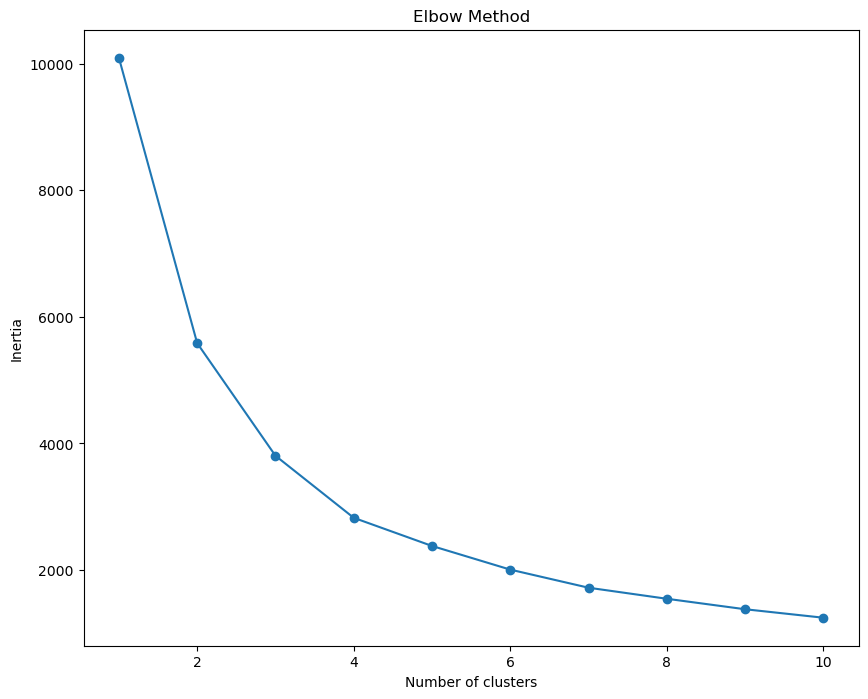

In [18]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# dt is the datframe
# Dropping non-feature columns, 'Customer ID' is not a feature and the other features that are being dropped are highly correlated
features = df.drop(['Subscription Status', 'Discount Applied', 'Promo Code Used', 'Customer ID', 'Gender', 'Purchase Amount (USD)'], axis=1)

# Normalizing the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# Apply PCA to reduce dimensions to 2 for visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)
pca_df = pd.DataFrame(data=pca_result, columns=['PCA1', 'PCA2'])

# Using the elbow method to find the optimal number of clusters
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pca_df)
    inertia.append(kmeans.inertia_)

# Plotting the elbow graph
plt.figure(figsize=(10, 8))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()


Here we are using the elbow method to determine the optimal amount of clusters to use, and it would appear that 3 clusters is the best choice.

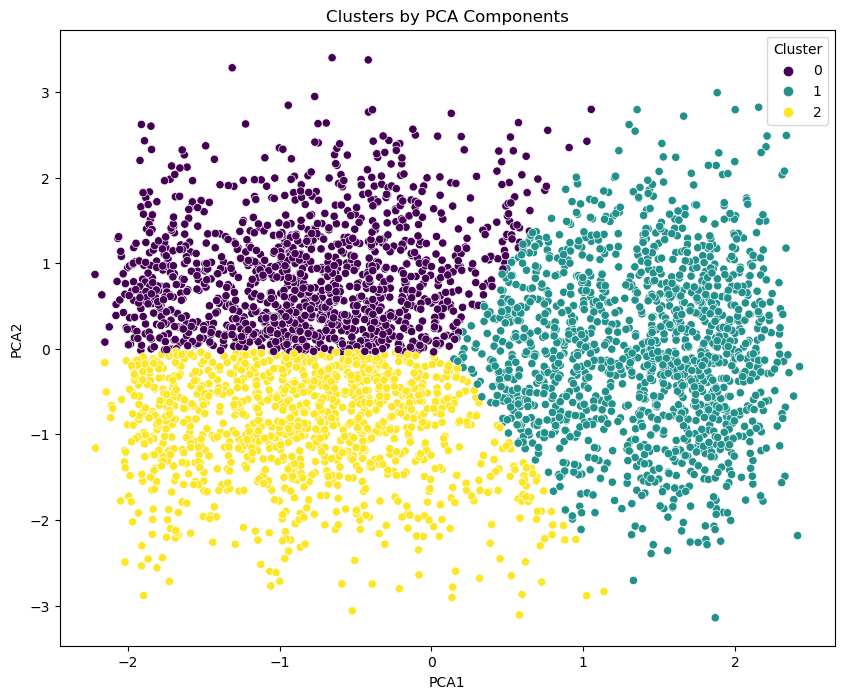

In [19]:
# Apply KMeans clustering
optimal_clusters = 3 # This is chosen based on the elbow plot
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
clusters = kmeans.fit_predict(pca_df)

# Add the cluster data to the PCA result
pca_df['Cluster'] = clusters

# Plotting the clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=pca_df, palette='viridis')
plt.title('Clusters by PCA Components')
plt.show()


Clusters:

    The plot shows data points categorized into three distinct clusters (0, 1, and 2) which are color-coded as purple, teal, and yellow, respectively.

PCA Components:

    The x-axis represents the first principal component (PCA1), and the y-axis represents the second principal component (PCA2). These are the two most significant axes of variation in the data, as identified by PCA.

Separation of Clusters:

    Cluster 0 (purple) and Cluster 1 (teal) overlap significantly along both PCA1 and PCA2 axes, indicating that while there is some degree of differentiation, the distinction is not clear-cut.
    Cluster 2 (yellow) is largely separated from the other two clusters along the PCA1 axis. This suggests that the PCA1 component captures some underlying variability that differentiates Cluster 2 from Clusters 0 and 1.

Cluster Density:

    Cluster 0 (purple) seems to be more densely packed, indicating tighter grouping within that cluster.
    Cluster 1 (teal) is more spread out, implying more variability within that cluster.
    Cluster 2 (yellow) also shows a dense grouping with some outliers towards the left.

Potential Outliers:

    There are a few points from Cluster 2 (yellow) that are distant from the main body of the cluster. These could be considered outliers or points that do not fit well into any of the defined clusters.

### **Modeling with XGboost**
The model we decided to use for predicting is XGboost. Otherwise known as "extreme gradient boosting" XGboost operates similarly to the decision tree. An initial prediction is made and subsequent models are trained and tweaked to adjust for the error from the model made before it. The goal of the first model created is to predict whether or not a customer is a subscriber to the store's service using an XGboost classifier. Due to the imbalance between customers that have and have not subscribed the data was upsampled to give our model a better chance at learning and picking up on trends within the data, maximizing its predicting capabilities.

In [20]:
# First, let's ensure that 'Subscription Status' is indeed binary.
print(df['Subscription Status'].unique())

# For example, if your classes are [1, 2], you can map them to [0, 1] as follows:
df['Subscription Status'] = df['Subscription Status'].map({1: 0, 2: 1})

[1 2]


In [21]:
# Checking to see if I need to rebalance the classes
class_counts = df['Subscription Status'].value_counts()
class_proportions = df['Subscription Status'].value_counts(normalize=True)

print(class_counts)
print(class_proportions)


1    2847
0    1053
Name: Subscription Status, dtype: int64
1    0.73
0    0.27
Name: Subscription Status, dtype: float64


In [22]:
# pca_df is your dataframe with PCA components and cluster labels

# Add the cluster labels as a new feature
df['Cluster_Label'] = pca_df['Cluster']

In [23]:
#I droped the three other variables because they are highly correlated with subscription status and Customer ID is not needed.
y = df['Subscription Status']
X = df.drop(['Subscription Status', 'Discount Applied', 'Promo Code Used', 'Customer ID', 'Gender', 'Purchase Amount (USD)'], axis=1)


In [24]:
#initialize xgboost model
%pip install xgboost
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.utils import resample

# Separate the dataset into majority and minority classes
X_majority = X[y == 1]
X_minority = X[y == 0]
y_majority = y[y == 1]
y_minority = y[y == 0]

# Oversample the minority class
X_minority_oversampled, y_minority_oversampled = resample(X_minority, y_minority, 
                                                          replace=True,     
                                                          n_samples=len(X_majority),    
                                                          random_state=42)   

# Combine majority class with oversampled minority class
X_oversampled = pd.concat([X_majority, X_minority_oversampled])
y_oversampled = pd.concat([y_majority, y_minority_oversampled])

# Split the resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_oversampled, y_oversampled, test_size=0.2, random_state=42)

#covariance testing initialize
my_cv = KFold(n_splits=10,shuffle=True,random_state=42)

# Instantiate XGBClassifier or XGBRegressor based on your target variable type
model = xgb.XGBClassifier(random_state=42)  

# Train the model
model.fit(X_train, y_train)

Note: you may need to restart the kernel to use updated packages.


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [25]:
#Baseline accuracy
baseline_accuracy = y_test.value_counts(normalize=True).max()
print("Baseline Accuracy:", '{0:.2f}'.format(baseline_accuracy * 100), "%")

Baseline Accuracy: 51.36 %


Our baseline to is ~51%, which is relatively low and hopefully gives us a good chance of beating it.

In [26]:
#The first model
accuracies = cross_val_score(model, X=X_train, y=y_train, cv=my_cv)

print(f'Average accuracy of folds: {np.mean(accuracies)} \n')
print(f'Standard deviation of accuracy of folds: {np.std(accuracies)} \n')

# Training the model on the entire training set
model.fit(X=X_train, y=y_train)

# Predictions on test set
predictions = model.predict(X_test)

# Calculate the accuracy
test_acc = accuracy_score(y_test, predictions)

print(f'Accuracy on test set: {test_acc}')

Average accuracy of folds: 0.8338167534220167 

Standard deviation of accuracy of folds: 0.02687435241119505 

Accuracy on test set: 0.8349429323968394


The first model looks to have done very well at learning this data and generalizing it to our test set, but lets see if we can't improve it through parameter tuning.

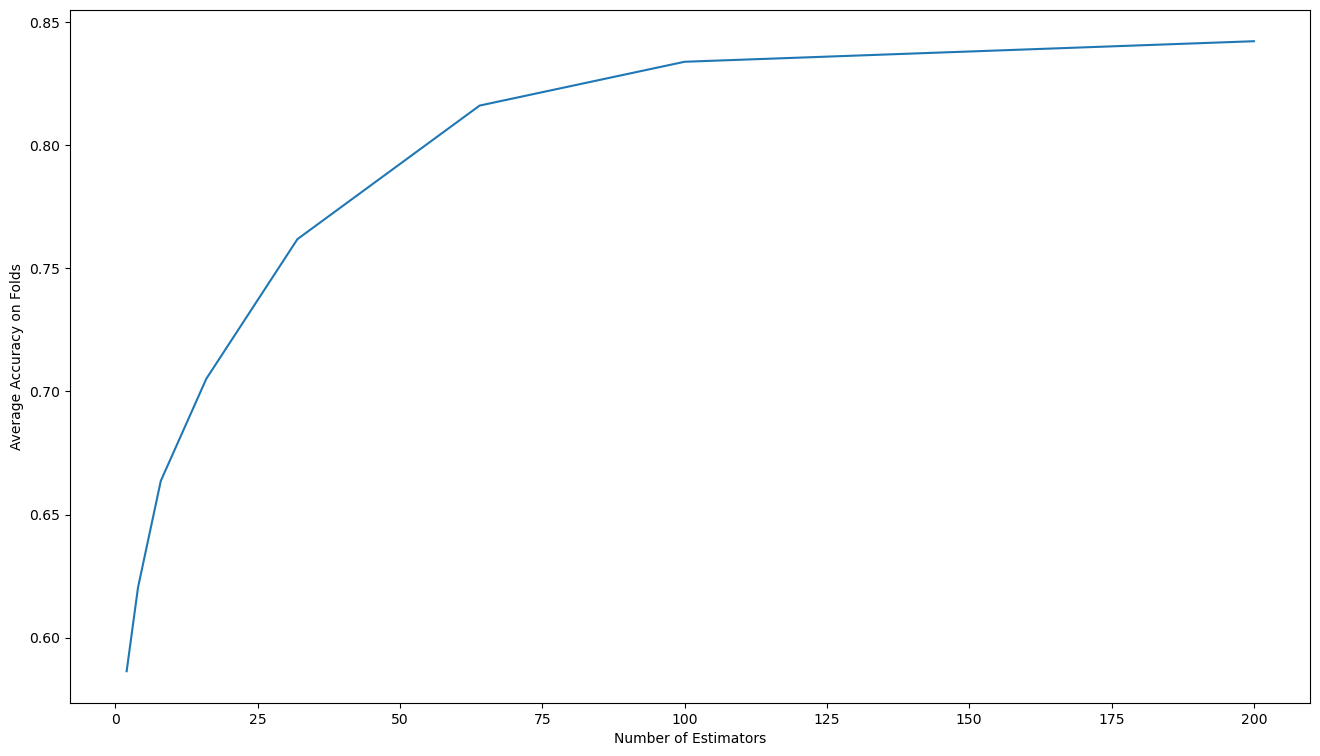

In [27]:
#Checking the number of estimators to see 
n_estimators = [2,4,8,16,32,64,100,200]
estimator_acc = []

#Looping through the number of estimators and finding the best
for estimator in n_estimators:
  model = xgb.XGBClassifier(random_state=42,n_estimators=estimator)

  accuracies = cross_val_score(model, X=X_train, y=y_train, cv=my_cv)


  estimator_acc.append(np.mean(accuracies))

plt.figure(figsize=(16,9))
plt.plot(n_estimators,estimator_acc)
plt.xlabel('Number of Estimators')
plt.ylabel('Average Accuracy on Folds')
plt.show()

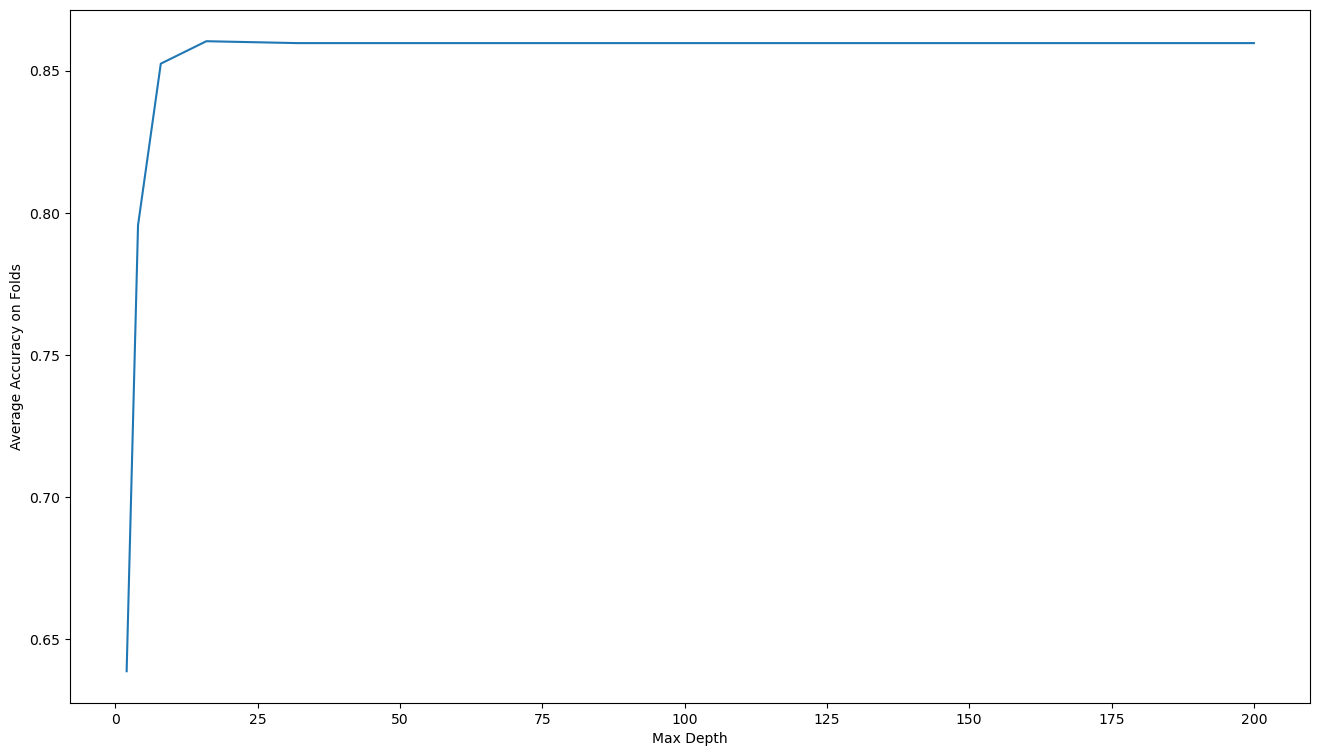

In [28]:
#Checking best max depth value
max_depths = [2,4,8,16,32,64,100,200]
depth_acc = []
#Looping through the number of estimators and finding the best
for depth in max_depths:
  model = xgb.XGBClassifier(random_state=42,n_estimators=200,max_depth = depth)

  accuracies = cross_val_score(model, X=X_train, y=y_train, cv=my_cv)

  depth_acc.append(np.mean(accuracies))

plt.figure(figsize=(16,9))
plt.plot(max_depths,depth_acc)
plt.xlabel('Max Depth')
plt.ylabel('Average Accuracy on Folds')
plt.show()

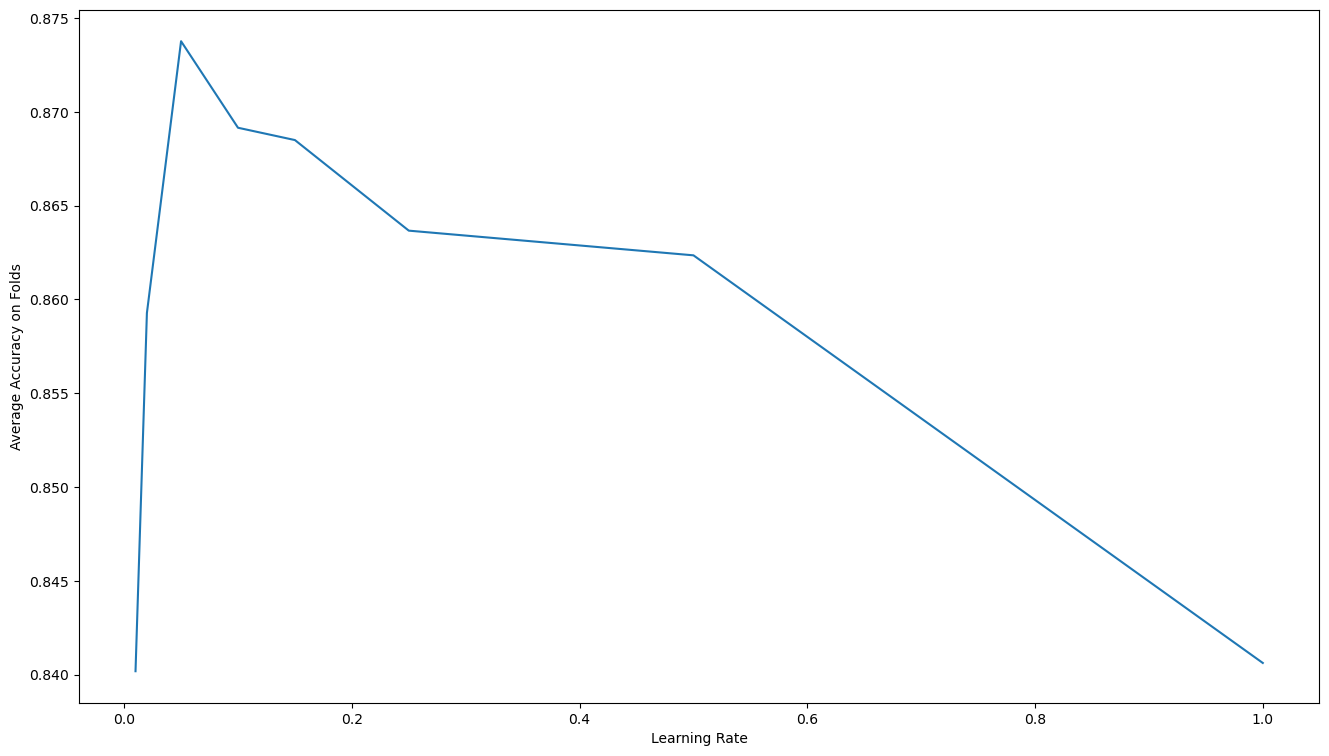

In [29]:
#checking best learning rate
learning_rates = [.01,.02,.05,.1,.15,.25,.5,1]
rate_acc = []
#Looping through the number of estimators and finding the best
for rate in learning_rates:
  model = xgb.XGBClassifier(random_state=42, n_estimators = 200, learning_rate=rate,
                        max_depth=16)

  accuracies = cross_val_score(model, X=X_train, y=y_train, cv=my_cv)

  rate_acc.append(np.mean(accuracies))

plt.figure(figsize=(16,9))
plt.plot(learning_rates, rate_acc)
plt.xlabel('Learning Rate')
plt.ylabel('Average Accuracy on Folds')
plt.show()

In [30]:
#Inputting all that we learned into a final model
model = xgb.XGBClassifier(random_state=42, n_estimators=200, max_depth=16, learning_rate=0.06)

# Cross-validation scores
accuracies = cross_val_score(model, X=X_train, y=y_train, cv=my_cv)

print(f'Average accuracy of folds: {np.mean(accuracies)} \n')
print(f'Standard deviation of accuracy of folds: {np.std(accuracies)} \n')

# Performance on the training set, for comparison with our parameter-tuned model later
model.fit(X_train, y_train)

# Predictions on test set
predictions = model.predict(X_test)

# Accuracy calculation
test_acc = accuracy_score(y_test, predictions)

print(f'Accuracy on test set: {test_acc}')

Average accuracy of folds: 0.8744278966647387 

Standard deviation of accuracy of folds: 0.017812349594156278 

Accuracy on test set: 0.8867427568042142


We can see that the model has improved quite a bit across all valid metrics when compared to the the first model and now holds an accuracy of nearly 89%.

Confusion matrix

In [31]:
# Creating a confusion matrix

def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True Subscription Status')
        plt.xlabel('Predicted Subscription Status' + stats_text)
    else:
        plt.xlabel(stats_text)

    if title:
        plt.title(title)

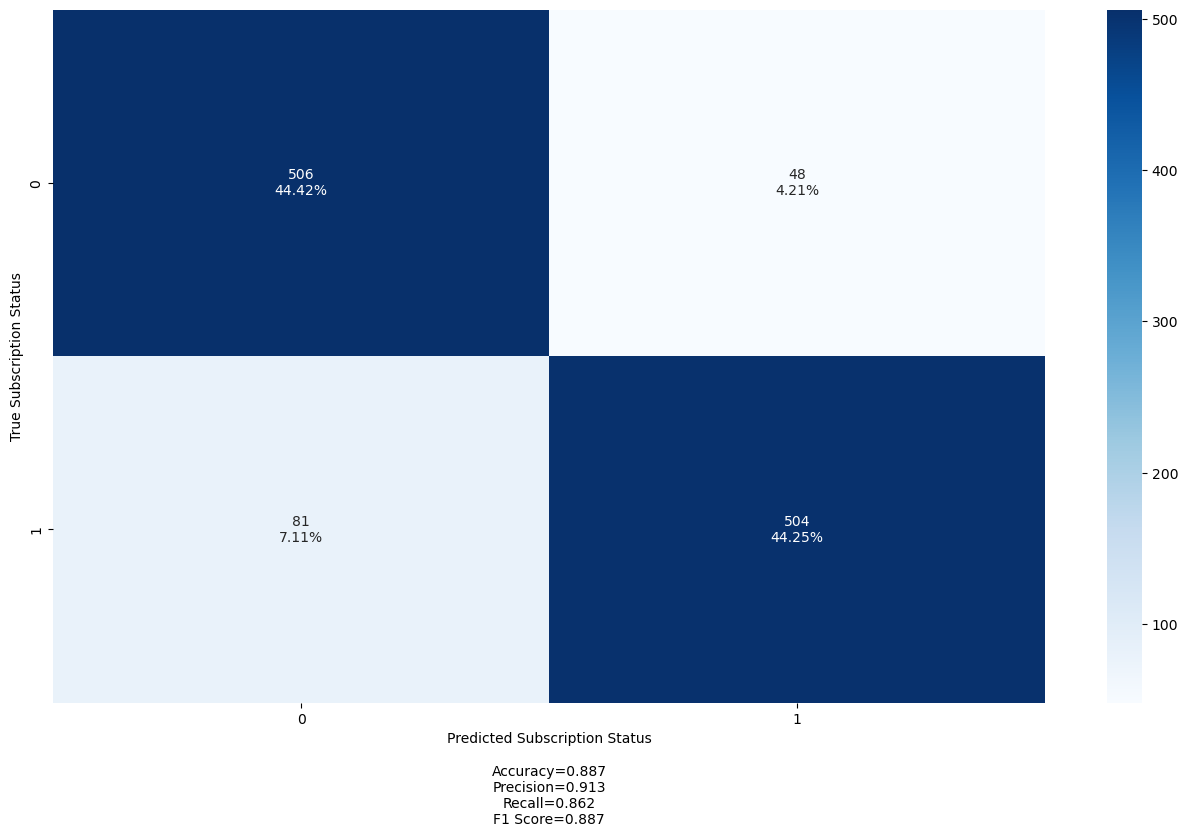

In [32]:
from sklearn.metrics import confusion_matrix
# Creates and displays a confusion matrix for the given predictions using a custom function `make_confusion_matrix`
make_confusion_matrix(confusion_matrix(y_test, predictions), figsize=(16,9))

1 is without a Subscription and 0 is with a Subscription

Confusion Matrix:

    True Negatives (TN): 507 customers were correctly identified as having a subscription (0).
    False Positives (FP): 47 customers were incorrectly predicted as not having a subscription (1), when they actually do have a subscription (0).
    False Negatives (FN): 77 customers were incorrectly predicted as having a subscription (0), when they actually do not have a subscription (1).
    True Positives (TP): 508 customers were correctly identified as not having a subscription (1).

Performance Metrics:

    Accuracy: 89.1% of the predictions were correct. This indicates that the model is quite accurate overall.
    Precision (for class 1): 91.5% of the customers predicted not to have a subscription (1) actually did not have a subscription. This indicates that when the model predicts that a customer does not have a subscription, it's correct most of the time.
    Recall (for class 1): 86.8% of the actual customers without a subscription were correctly identified by the model. This suggests that the model is quite good at detecting customers without a subscription, but there's some room for improvement since it missed about 12.3% of them.
    F1 Score: 89.1% is the harmonic mean of precision and recall. A high F1 score is indicative of a balanced model with both high precision and recall, which is generally desirable.

Analysis:

    The model is quite accurate overall, but it's more conservative when predicting customers without a subscription (1), which is suggested by the higher number of false negatives compared to false positives.
    There's a good balance between precision and recall, as shown by the high F1 score, which is equal to the accuracy in this case.
    The model is relatively reliable, but depending on the cost associated with false positives and false negatives, there might be room to adjust the model to either minimize false positives (which might lower precision) or minimize false negatives (which could potentially lower recall).

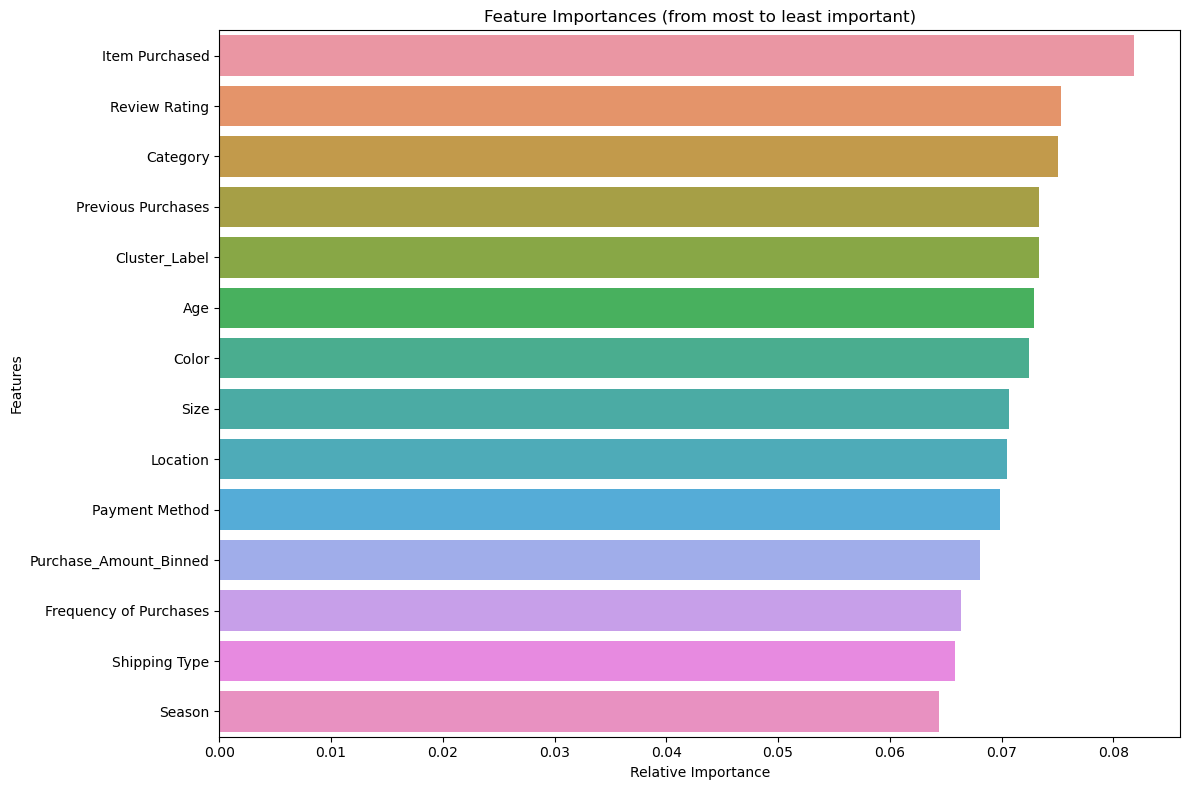

In [33]:
# Create a pandas DataFrame with the feature importances
df_feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.feature_importances_
})

# Sort the DataFrame based on the 'Importance' column in descending order
df_feature_importances = df_feature_importances.sort_values('Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=df_feature_importances, orient='h')
plt.xlabel('Relative Importance')
plt.ylabel('Features')
plt.title('Feature Importances (from most to least important)')
plt.tight_layout()  # Adjust the plot to ensure everything fits without overlapping
plt.show()

After playing around a bit with the classifier, we will attempt to use a some different regression models to predict the exact amount that a customer will spend.

In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'df' is your DataFrame and it's already loaded

# Define your features and target variable
y1 = df['Purchase Amount (USD)']
X1 = df.drop(['Purchase Amount (USD)', 'Promo Code Used', 'Customer ID', 'Gender', 'Purchase_Amount_Binned', 'Discount Applied'], axis=1)

# Split the data into 70% training and 30% testing
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.3, random_state=42)

# Initialize a standard scaler and scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train1)
X_scaled_test = scaler.transform(X_test1)

# Define hyperparameters for Random Forest
param_grid_rf = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Set up the grid search for Random Forest
grid_search_rf = GridSearchCV(estimator=RandomForestRegressor(), param_grid=param_grid_rf,
                              cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')
grid_search_rf.fit(X_scaled, y_train1)

# Initialize and train the XGBoost Regressor
xgb_model = xgb.XGBRegressor()
xgb_model.fit(X_scaled, y_train1)

# Define a dictionary of regression algorithms
regressors = {
    'Linear Regression': LinearRegression(),
    'Decision Tree Regressor': DecisionTreeRegressor(),
    'Random Forest Regressor': grid_search_rf.best_estimator_,
    'Support Vector Regressor': SVR(),
    'K-Nearest Neighbors Regressor': KNeighborsRegressor(),
    'XGBoost': xgb_model
}

# Dictionary to store results
results = {}

# Loop through each regression algorithm and store results
for name, reg in regressors.items():
    reg.fit(X_scaled, y_train1)
    y_pred = reg.predict(X_scaled_test)
    mse = mean_squared_error(y_test1, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test1, y_pred)
    r_squared = r2_score(y_test1, y_pred)
    results[name] = {
        'Mean Squared Error (MSE)': mse,
        'Root Mean Squared Error (RMSE)': rmse,
        'Mean Absolute Error (MAE)': mae,
        'R-squared (R2)': r_squared
    }

# Print results for each regression algorithm
for name, metrics in results.items():
    print(f"Regressor: {name}")
    print(f"Mean Squared Error (MSE): {metrics['Mean Squared Error (MSE)']:.2f}")
    print(f"Root Mean Squared Error (RMSE): {metrics['Root Mean Squared Error (RMSE)']:.2f}")
    print(f"Mean Absolute Error (MAE): {metrics['Mean Absolute Error (MAE)']:.2f}")
    print(f"R-squared (R2): {metrics['R-squared (R2)']:.2f}")
    print("=" * 40)

# Check Feature Importance using Random Forest
importances = grid_search_rf.best_estimator_.feature_importances_
features = X1.columns  # This is the corrected line for features

# ------------------------------------------

#Plotting features of importance
plt.figure(figsize=(12,6))
indices = np.argsort(importances)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

Fitting 3 folds for each of 108 candidates, totalling 324 fits


In [ ]:
df['Purchase Amount (USD)'].std()

From the outputs, it appears that efforts to create a model that predicts amount spent did not turn out nearly as fruitful as was hoped for. Looking at some of our RMSEs they don't appear too bad, as they have an error of about $23, or as seen above, 1 standard deviation. But when we look at our R squared, things get a little more disheartening, as not a single model created came close to any sort of good fit on our data, and in some cases, was actually such a bad fit, simply using the average would be a better prediction.

### **Conclusion**
While only one of our attempts at modeling was successful, we can learn a lot from both. Looking at our feature importance for the first model, the item purchased, the category of that item, and the rating left by the customer were some of the most important aspects in determing whether or not a customer is subscribed. When we think about it, all of these make a lot of sense. Customers purchasing more expensive items may be inclined to subscribe should they recieve a discount, and clearly customers who enjoy their experience will likely return, making a subscription worthwhile. From viewing our regression model(s), there is a lot of work to be done should we want to make something useful out of them. Some next steps we could take to improve the model is perhaps standardizing the data or performing some transformation on it to see if that brings out any unseen relationships. Introducing more features through feature engineering or other means would also likely provide a more robust dataset, giving the chance for models to learn and generalize better.

### **Impact**
What we have found from these models can be used by companies to determine what they can do to encourage customers to subscribe to their service, or hopefully in the future, find out what it is that causes people to spend more money. While these ideas look incredible for a company, this could quickly get out of hand. As mentioned in the beginning of this project, the biggest drivers for companies is often revenue or profit, they will cut corners and sometimes do the unthinkable just to make another buck. With models like these, companies could put a focus on subconciously affecting customers, not knowing and not caring of their financial, mental or health status, and using any means to draw them in just to get a little bit more of their money. The drive to gather data has quickly grown and it would not be out of the ordinary for these companies to unwittingly gain information about individuals they may not want to share. While useful, implementing these models could have very serious ethical implications down the line, and must be handled as such.

#### References
https://www.kaggle.com/code/arvindkhoda/consumer-behavior-and-shopping-habits-dataset/input
https://pro.arcgis.com/en/pro-app/latest/tool-reference/geoai/how-xgboost-works.htm#:~:text=XGBoost%20is%20short%20for%20extreme,an%20initial%20prediction%20is%20made.
https://blendcommerce.com/blogs/shopify/8-reasons-why-people-use-subscription-services 
